In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.utils import save_image, make_grid
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
import os

# Path to the zip file on the google drive
zip_path = '/content/drive/MyDrive/Colab Notebooks/lfw.zip'

# Path for unzipped file
extracted_path = './lfw/'

# Making directory for extraction
if not os.path.exists(extracted_path):
    os.makedirs(extracted_path)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

path = '/content/lfw/lfw'

In [3]:
path = './lfw'

In [4]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


torch.Size([250, 250, 3])


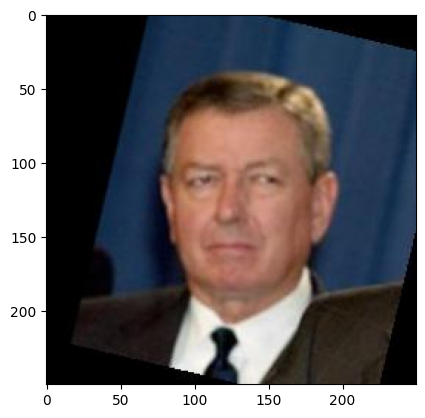

In [5]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [7]:
# print(x.shape)

torch.Size([250, 250, 3])


In [7]:
# Getting the random sample
random_batch = next(iter(dataloader))
random_image = random_batch
print(random_image[0].shape)

torch.Size([32, 3, 250, 250])


**32** is the batch size

**3** is the dimension signifies the number of channels in the image tensor. For this RGB (Red, Green, Blue) image, this value of 3 indicates three channels representing the intensity of each color.

**250**  denotes the height of the image tensor, indicating that the image has a height of 250 pixels.

**250** is dimension represents the width of the image tensor, specifying that the image has a width of 250 pixels.



# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

* After closely examining each of the tested models, the Autoencoder listed below was determined to be the primary model.

**Justifications**
 * With normal convolutions and activation functions, the model produces a well-decoded image without the need for pooling, batch normalization, or downsampling. Argument : Max-pooling (or any kind of pooling) is a fixed operation and replacing it with a strided convolution can also be seen as learning the pooling operation, which increases the model's expressiveness ability.
 * Stride = 2 in the main model serves as a pooling operation, and the decoded image is improved as seen in the model below.

**Model Details**
 * Simple Convolutional Model with Activations functions. Its follows the Convolutional Stages :
 * First Stage : Convolutional with Kernels
 * Second Stage : Detector Stage with Activation Functions
 * Third Stage : Pooling or any downsampling Stage - Currently these are with Convolutional with Stride as mentioned earlier
   
 

In [23]:
## main model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1), # (32, 16, 125, 125)
            nn.ReLU(True),

            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # (32, 32, 63, 63)
            nn.ReLU(True),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # (32, 64, 32, 32)
            nn.ReLU(True),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # (32, 128, 16, 16)
            nn.ReLU(True)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1,output_padding=1), # (32, 64, 32, 32)
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1), # (32, 32, 63, 63)
            nn.ReLU(True),

            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1), # (32, 16, 125, 125)
            nn.ReLU(True),

            nn.ConvTranspose2d(16, 3, kernel_size= 3, stride=2, padding=1,output_padding=1), # (32, 3, 250, 250)
            nn.Sigmoid()
        )

    def forward(self, x):

        # print("Shape Before Encoding: ", x.shape)
        x_e = self.encoder(x)
        # print("Shape after Encoding: ", x_e.shape)
        x_d = self.decoder(x_e)
        # print("Finished Decoding: ", x_d.shape)
        return x_d

## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [25]:
model1 = Autoencoder()

In [11]:
output_tensor = model1(random_image)

Shape Before Encoding:  torch.Size([32, 3, 250, 250])
Shape after Encoding:  torch.Size([32, 128, 16, 16])
Finished Decoding:  torch.Size([32, 3, 250, 250])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [26]:
total_trainable_params = sum(p.numel() for p in model1.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_trainable_params}")

Total Trainable Parameters: 194755


In [27]:
learning_rate = 0.01

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=learning_rate)

scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

* If your loss is not decreasing steps - Recheck the below things:
 * The choice of loss function is directly related to the activation function used in the output layer of your neural network - so reconsider the loss function you have selected.
 * Extremely high error rates can result from an excessive learning rate that either puts you out of reach of any local minima or traps you in an optimization cycle.
 * I might increase number of kernels in convolutional layers and reducing the batch size

In [28]:

model1 = Autoencoder()

total_trainable_params = sum(p.numel() for p in model1.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_trainable_params}")
learning_rate = 0.01
import torch.optim as optim
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=learning_rate)

scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
num_epochs = 40
model1.to(device)
print(device)

for epoch in range(num_epochs):
    total_loss = 0
    for i, data in enumerate(dataloader, 0):
        inputs, _ = data
        inputs = inputs.to(device)


        optimizer.zero_grad()

        # Forward pass
        outputs = model1(inputs)


        loss = loss_function(outputs, inputs)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()


    scheduler.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, total_loss))

print("Finished Training")

Total Trainable Parameters: 194755
cuda
epoch [1/40], loss:5.1410
epoch [2/40], loss:1.2872
epoch [3/40], loss:0.9437
epoch [4/40], loss:0.8263
epoch [5/40], loss:0.7672
epoch [6/40], loss:0.7073
epoch [7/40], loss:0.6905
epoch [8/40], loss:0.6547
epoch [9/40], loss:0.6366
epoch [10/40], loss:0.6201
epoch [11/40], loss:0.4186
epoch [12/40], loss:0.3330
epoch [13/40], loss:0.3197
epoch [14/40], loss:0.3113
epoch [15/40], loss:0.3196
epoch [16/40], loss:0.2872
epoch [17/40], loss:0.2938
epoch [18/40], loss:0.2710
epoch [19/40], loss:0.2694
epoch [20/40], loss:0.2557
epoch [21/40], loss:0.2083
epoch [22/40], loss:0.2065
epoch [23/40], loss:0.2084
epoch [24/40], loss:0.2073
epoch [25/40], loss:0.2054
epoch [26/40], loss:0.2012
epoch [27/40], loss:0.2019
epoch [28/40], loss:0.1999
epoch [29/40], loss:0.1960
epoch [30/40], loss:0.1923
epoch [31/40], loss:0.1765
epoch [32/40], loss:0.1757
epoch [33/40], loss:0.1762
epoch [34/40], loss:0.1766
epoch [35/40], loss:0.1749
epoch [36/40], loss:0.17

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

In [29]:
def plot_image_pair(x,y):
    x_np = x.detach().cpu().squeeze().numpy()
    y_np = y.detach().cpu().squeeze().numpy()

    # Transpose the axes if needed
    x_np = np.transpose(x_np, (1, 2, 0))
    y_np = np.transpose(y_np, (1, 2, 0))

    plt.subplot(121)
    plt.imshow(x_np)
    plt.title("Original Image")


    plt.subplot(122)
    plt.imshow(y_np)
    plt.title("Decoded Image")

    plt.show()

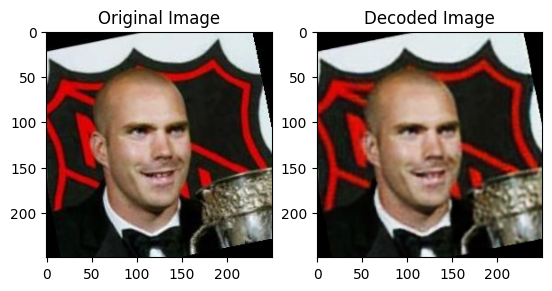

In [61]:
for i, data in enumerate(dataloader, 0):
    inputs, _ = data
    inputs = inputs.to(device)
    xt = model1(inputs)
    plot_image_pair(inputs[1], xt[1])
    break  # Only visualize the first batch for simplicity

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

* The model still functions well by providing a decent enough noise reduction image, as demonstrated below, even with the addition of noise (Gaussian noise) at the encoded [Latent space]. The decoder should then be able to reconstruct the original image with noise reduction.
* However, the reason it isn't providing us with the ideal image is that our model was trained to compress the image and extract the data, not to denoise it. Thus, it's not that good.



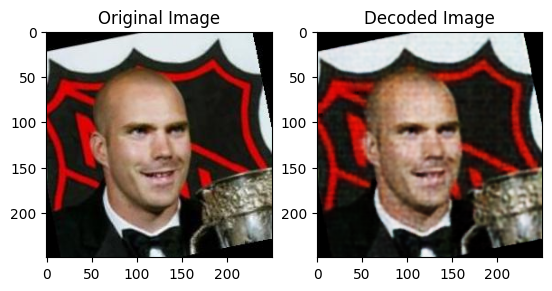

In [63]:
import torch
import numpy as np

# Function to add noise to the latent representation
def add_noise_to_latent_representation(latent_repr, std_dev=0.1):
    noise = torch.normal(mean=0.1, std=std_dev, size=latent_repr.size(), device=latent_repr.device)
    noisy_latent = latent_repr + noise
    return noisy_latent

# Get the latent representation
latent_representation = model1.encoder(inputs)

# Add noise to the latent representation
noisy_latent = add_noise_to_latent_representation(latent_representation, std_dev=0.1)

# Decode the noisy latent representation
decoded_noisy = model1.decoder(noisy_latent)


plot_image_pair(inputs[1], decoded_noisy[1])

## Different Tested Models

## Model 2

The model didn't work well; there was a lot of information lost during compression, and the decoded image wasn't very crisp.

**Justifications**
 * Pooling/sub-sampling does discard spatial information, it is mainly applied in order to reduce the parameter count as well as to introduce tolerance to distortions due to changes in view point and other distortions in the stimuli. So the small details aren't captured well and hence bad reconstructed image as shown.

In [ ]:
# second model

class AE2(nn.Module):

    def __init__(self):
        super(AE2,self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 64, kernel_size=3, stride=1,padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2),
        )

        self.decoder = nn.Sequential(
            nn.Upsample(mode='bilinear', scale_factor=2),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),

            nn.Upsample(mode='bilinear', scale_factor=2),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),

            nn.Upsample(mode='bilinear', scale_factor = 2),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1),
            nn.ReLU(True),
        )


    def forward(self,x):

        # print("Input Shape: ", x.shape)
        x_en = self.encoder(x)
        # print("Encoded Shape: ", x_en.shape)
        x_De = self.decoder(x_en)
        # print("Decoded Shape: ", x_De.shape)
        return x_De

In [ ]:
model2 = AE2()

In [ ]:
output_tensor = model2(random_image)

Input Shape:  torch.Size([32, 3, 250, 250])
Encoded Shape:  torch.Size([32, 64, 31, 31])
Decoded Shape:  torch.Size([32, 3, 250, 250])


In [ ]:
# second model

num_epochs = 40
model2.to(device)
print(device)

for epoch in range(num_epochs):
    total_loss = 0
    for i, data in enumerate(dataloader, 0):
        inputs, _ = data

        inputs = inputs.to(device)


        optimizer.zero_grad()

        # Forward pass
        outputs = model2(inputs)

        loss = loss_function(outputs, inputs)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()


    scheduler.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, total_loss))

print("Finished Training")

cuda
epoch [1/40], loss:12.9716
epoch [2/40], loss:1.8053
epoch [3/40], loss:1.3958
epoch [4/40], loss:1.2133
epoch [5/40], loss:1.1050
epoch [6/40], loss:1.0237
epoch [7/40], loss:0.9485
epoch [8/40], loss:0.8929
epoch [9/40], loss:0.8487
epoch [10/40], loss:0.8111
epoch [11/40], loss:0.7804
epoch [12/40], loss:0.7562
epoch [13/40], loss:0.7326
epoch [14/40], loss:0.7124
epoch [15/40], loss:0.6990
epoch [16/40], loss:0.6839
epoch [17/40], loss:0.6700
epoch [18/40], loss:0.6612
epoch [19/40], loss:0.6454
epoch [20/40], loss:0.6386
epoch [21/40], loss:0.6308
epoch [22/40], loss:0.6169
epoch [23/40], loss:0.6131
epoch [24/40], loss:0.6009
epoch [25/40], loss:0.5944
epoch [26/40], loss:0.5881
epoch [27/40], loss:0.5804
epoch [28/40], loss:0.5736
epoch [29/40], loss:0.5679
epoch [30/40], loss:0.5619
epoch [31/40], loss:0.5554
epoch [32/40], loss:0.5512
epoch [33/40], loss:0.5450
epoch [34/40], loss:0.5435
epoch [35/40], loss:0.5321
epoch [36/40], loss:0.5316
epoch [37/40], loss:0.5273
epoc

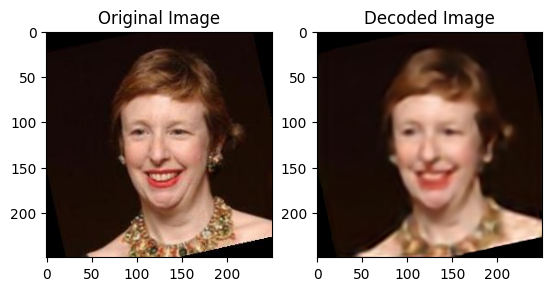

In [ ]:
# second model

for i, data in enumerate(dataloader, 0):
    inputs, _ = data
    inputs = inputs.to(device)

    xt = model2(inputs)
    plot_image_pair(inputs[1], xt[1])
    break  


## Model 3

This model is leveraged on Model 2 which was failure
 * The reconstructed image is marginally better than Model 2 due to less pooling and downsampling of the input size, but the output is not better. Was attempting to avoid compressing more less reduction in input size and the color channels were kept the same. However, pooling and upsampling was used and thus drew the conclusion that pooling can be the main issue for loss of spatial information.

In [ ]:
class AE3(nn.Module):
    def __init__(self):
        super(AE3, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 16, kernel_size=2, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 3, kernel_size=2, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # print("Shape before encoding", x.shape)
        x_e = self.encoder(x)
        # print("Shape before encoding", x_e.shape)
        x_d = self.decoder(x_e)
        # print("Shape before encoding", x_d.shape)
        return x_d

In [ ]:
model3 = AE3()

In [ ]:
output_tensor = model3(random_image)

Shape before encoding torch.Size([32, 3, 250, 250])
Shape before encoding torch.Size([32, 16, 62, 62])
Shape before encoding torch.Size([32, 3, 250, 250])


In [ ]:
total_trainable_params = sum(p.numel() for p in model3.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_trainable_params}")
learning_rate = 0.001
import torch.optim as optim
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=learning_rate)

scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
num_epochs = 40  # Number of training epochs
model3.to(device)  # Move the model to GPU, if available
print(device)

for epoch in range(num_epochs):
    total_loss = 0
    for i, data in enumerate(dataloader, 0):
        inputs, _ = data
        inputs = inputs.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model3(inputs)

        loss = loss_function(outputs, inputs)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, total_loss))

print("Finished Training")

Total Trainable Parameters: 24611
cuda
epoch [1/40], loss:2.7618
epoch [2/40], loss:0.5771
epoch [3/40], loss:0.4507
epoch [4/40], loss:0.3793
epoch [5/40], loss:0.3037
epoch [6/40], loss:0.2663
epoch [7/40], loss:0.2484
epoch [8/40], loss:0.2245
epoch [9/40], loss:0.2194
epoch [10/40], loss:0.2057
epoch [11/40], loss:0.1824
epoch [12/40], loss:0.1774
epoch [13/40], loss:0.1752
epoch [14/40], loss:0.1748
epoch [15/40], loss:0.1710
epoch [16/40], loss:0.1671
epoch [17/40], loss:0.1643
epoch [18/40], loss:0.1607
epoch [19/40], loss:0.1574
epoch [20/40], loss:0.1558
epoch [21/40], loss:0.1465
epoch [22/40], loss:0.1443
epoch [23/40], loss:0.1431
epoch [24/40], loss:0.1425
epoch [25/40], loss:0.1404
epoch [26/40], loss:0.1386
epoch [27/40], loss:0.1380
epoch [28/40], loss:0.1359
epoch [29/40], loss:0.1346
epoch [30/40], loss:0.1338
epoch [31/40], loss:0.1307
epoch [32/40], loss:0.1301
epoch [33/40], loss:0.1295
epoch [34/40], loss:0.1289
epoch [35/40], loss:0.1284
epoch [36/40], loss:0.127

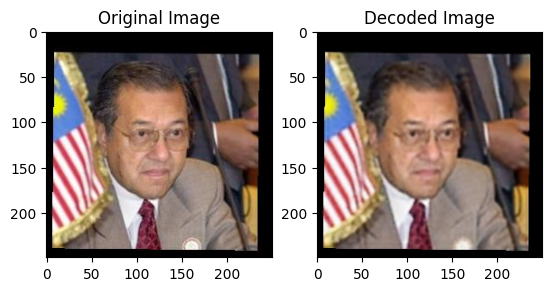

In [ ]:
for i, data in enumerate(dataloader, 0):
    inputs, _ = data
    inputs = inputs.to(device)
    xt = model3(inputs)
    plot_image_pair(inputs[1], xt[1])
    break  # Only visualize the first batch for simplicity

## Model 4

* Excellent reconstruction still not my best model why?

* Becuase the compression is set to 125, it is evident that nothing is being encoded, and the reconstructed image from this model is fairly excellent and clear. - Good Image with Bad model which is not our goal.

In [ ]:
class AE4(nn.Module):
    def __init__(self):
        super(AE4, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),

            nn.Upsample(scale_factor=1, mode='nearest'),
            nn.Conv2d(64, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),


            nn.Conv2d(16, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # print("Shape before encoding", x.shape)
        x_e = self.encoder(x)
        # print("Shape before encoding", x_e.shape)
        x_d = self.decoder(x_e)
        # print("Shape before encoding", x_d.shape)
        return x_d

# Create an instance of the autoencoder
model4 = AE4()

In [ ]:
output_tensor = model4(random_image)

Shape before encoding torch.Size([32, 3, 250, 250])
Shape before encoding torch.Size([32, 128, 125, 125])
Shape before encoding torch.Size([32, 3, 250, 250])


In [ ]:
model4 = AE4()

total_trainable_params = sum(p.numel() for p in model4.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_trainable_params}")
learning_rate = 0.001
import torch.optim as optim
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model4.parameters(), lr=learning_rate)

scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
num_epochs = 40
model4.to(device)
print(device)

for epoch in range(num_epochs):
    total_loss = 0
    for i, data in enumerate(dataloader, 0):
        inputs, _ = data

        inputs = inputs.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model4(inputs)

        loss = loss_function(outputs, inputs)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, total_loss))

print("Finished Training")

Total Trainable Parameters: 159107
cuda
epoch [1/40], loss:1.9226
epoch [2/40], loss:0.1692
epoch [3/40], loss:0.1032
epoch [4/40], loss:0.0831
epoch [5/40], loss:0.0735
epoch [6/40], loss:0.0663
epoch [7/40], loss:0.0592
epoch [8/40], loss:0.0542
epoch [9/40], loss:0.0506
epoch [10/40], loss:0.0465
epoch [11/40], loss:0.0345
epoch [12/40], loss:0.0333
epoch [13/40], loss:0.0335
epoch [14/40], loss:0.0335
epoch [15/40], loss:0.0329
epoch [16/40], loss:0.0313
epoch [17/40], loss:0.0314
epoch [18/40], loss:0.0301
epoch [19/40], loss:0.0289
epoch [20/40], loss:0.0291
epoch [21/40], loss:0.0243
epoch [22/40], loss:0.0239
epoch [23/40], loss:0.0237
epoch [24/40], loss:0.0237
epoch [25/40], loss:0.0233
epoch [26/40], loss:0.0234
epoch [27/40], loss:0.0225
epoch [28/40], loss:0.0226
epoch [29/40], loss:0.0216
epoch [30/40], loss:0.0216
epoch [31/40], loss:0.0202
epoch [32/40], loss:0.0200
epoch [33/40], loss:0.0199
epoch [34/40], loss:0.0197
epoch [35/40], loss:0.0194
epoch [36/40], loss:0.01

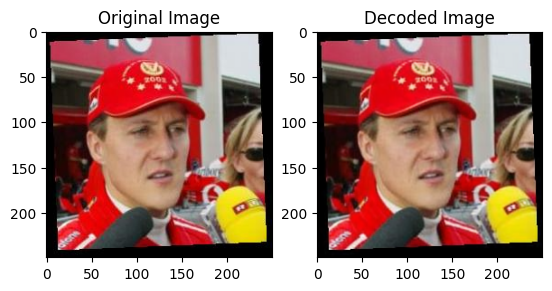

In [ ]:
for i, data in enumerate(dataloader, 0):
    inputs, _ = data
    inputs = inputs.to(device)
    xt = model4(inputs)
    plot_image_pair(inputs[1], xt[1])
    break  

## Model 5

* This more closely resembles Model 2, which was mentioned earlier. Increasing the color channel while maintaining the same level of compression as Model 2 yields the same results without any advantages.

**Justifications**
  * Given that colors are the primary characteristic, it's possible that these local variations aren't the most important thing for your kernels to learn how to extract. This is shown by.

In [64]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        # Downsample layers
        self.downsample = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Upsample layers
        self.upsample = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),

            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),

            nn.Conv2d(64, 32, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        )

        # Final convolution to get to 16x16 size
        self.final_conv = nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # print("the shape before", x.shape)
        x_e = self.downsample(x)
        # print("the shape after Encondign", x_e.shape)
        x_d = self.upsample(x_e)
        # print("the shape after Decodoing ", x_d.shape)
        x_l = self.final_conv(x_d)
        # print("the shape at last ", x_l.shape)
        return x_l

In [ ]:
model5 = ConvNet()
output_tensor = model5(random_image)

the shape before torch.Size([32, 3, 250, 250])
the shape after Encondign torch.Size([32, 256, 31, 31])
the shape after Decodoing  torch.Size([32, 32, 250, 250])
the shape at last  torch.Size([32, 3, 250, 250])


In [ ]:
model5 = ConvNet()

total_trainable_params = sum(p.numel() for p in model5.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_trainable_params}")
learning_rate = 0.001
import torch.optim as optim
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model5.parameters(), lr=learning_rate)

scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
num_epochs = 30
model5.to(device)
print(device)

for epoch in range(num_epochs):
    total_loss = 0
    for i, data in enumerate(dataloader, 0):
        inputs, _ = data
        inputs = inputs.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model5(inputs)

        loss = loss_function(outputs, inputs)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    scheduler.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, total_loss))

print("Finished Training")

Total Trainable Parameters: 750083
cuda
epoch [1/30], loss:5.7041
epoch [2/30], loss:1.5736
epoch [3/30], loss:1.3060
epoch [4/30], loss:1.2119
epoch [5/30], loss:1.0631
epoch [6/30], loss:0.9724
epoch [7/30], loss:1.0016
epoch [8/30], loss:0.8874
epoch [9/30], loss:0.9247
epoch [10/30], loss:0.7898
epoch [11/30], loss:0.6614
epoch [12/30], loss:0.6269
epoch [13/30], loss:0.6426
epoch [14/30], loss:0.6277
epoch [15/30], loss:0.6111
epoch [16/30], loss:0.5740
epoch [17/30], loss:0.5670
epoch [18/30], loss:0.5499
epoch [19/30], loss:0.5416
epoch [20/30], loss:0.5208
epoch [21/30], loss:0.4414
epoch [22/30], loss:0.4462
epoch [23/30], loss:0.4315
epoch [24/30], loss:0.4252
epoch [25/30], loss:0.4274
epoch [26/30], loss:0.4096
epoch [27/30], loss:0.4149
epoch [28/30], loss:0.3990
epoch [29/30], loss:0.3996
epoch [30/30], loss:0.3906
Finished Training


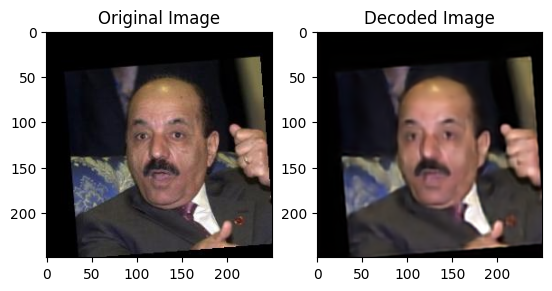

In [ ]:
for i, data in enumerate(dataloader, 0):
    inputs, _ = data
    inputs = inputs.to(device)
    xt = model5(inputs)
    plot_image_pair(inputs[1], xt[1])
    break 